<a href="https://colab.research.google.com/github/KJOELJOYSON2427/NLP_SENTIMENTAL_ANALYSIS/blob/main/sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [96]:
df=pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv")


In [97]:
df.head(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [98]:
df =df[['Review Text','Recommended IND']]


In [99]:
#Get Dimension of the Data
df.shape

(23486, 2)

In [100]:
df.rename(columns={
    'Review Text':'review_text','Recommended IND':'recommended'
}, inplace=True)

In [101]:
df.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


In [102]:
#Checking and Handling Missing Values
df.isna().sum()

,0
review_text,845
recommended,0


In [103]:
df['review_text']= df['review_text'].fillna(' ')

In [104]:
df.isna().sum()

,0
review_text,0
recommended,0


In [105]:
df.dtypes

,0
review_text,object
recommended,int64


In [106]:
#Exploratory Data Analysis (EDA)
df.loc[df["recommended"] == 0, "recommended"]= "Not Recommended" # 0 -> Not Recommended
df.loc[df["recommended"] == 1, "recommended"] = "Recommended" # 1 -> Recommended

/tmp/ipython-input-4194032853.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Recommended' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["recommended"] == 0, "recommended"]= "Not Recommended" # 0 -> Not Recommended


In [107]:
df.dtypes

,0
review_text,object
recommended,object


In [108]:
#Check Proportion Target Class Variable
count_class = df.value_counts(df["recommended"],sort=True)

In [109]:
count_class

,count
recommended,
Recommended,19314
Not Recommended,4172


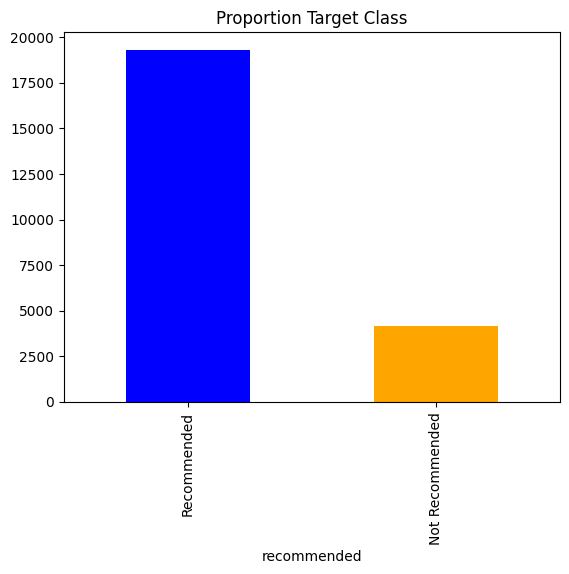

In [110]:
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [111]:
print('Recommended', round(df['recommended'].value_counts()['Recommended']/df.shape[0]*100), '%')

Recommended 82 %


In [112]:
print('Not Recommended', round(df['recommended'].value_counts()['Not Recommended']/df.shape[0]*100), '%')

Not Recommended 18 %


In [113]:
#Check Most Common Words in Each Target Variable Values
count1 =Counter(" ".join(df[df['recommended']=="Recommended"]['review_text']).\
                split()).most_common(20)

In [114]:
count1

[('the', 58954),
 ('i', 40789),
 ('and', 40389),
 ('a', 35828),
 ('it', 29788),
 ('is', 25523),
 ('to', 19767),
 ('this', 16676),
 ('in', 16506),
 ('but', 12601),
 ('for', 11337),
 ('with', 11250),
 ('on', 10795),
 ('of', 10512),
 ('so', 9453),
 ('my', 9024),
 ('was', 7955),
 ('that', 7462),
 ('I', 6964),
 ('not', 6944)]

In [115]:
df1 = pd.DataFrame.from_dict(count1)
df1

,0,1
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [116]:
df1=df1.rename(columns={
    0:"commom_words", 1:"cout"
})
df1.head(10)

,commom_words,cout
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [117]:
count2 = Counter(" ".join(df[df['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)

In [118]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


In [119]:
df.iloc[1,0]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

Text Mining

In [120]:
tokenizer =ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english'
)


In [121]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
main_text = df['review_text']
target = df['recommended']

print(len(main_text))
print(len(target))

23486
23486


In [123]:
contractions_dict = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
                           "how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
                           "they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
                           "they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have"
}


In [124]:

def expand_match(contraction):
    match =contraction.group(0)
    expanded_contraction= contractions_dict.get(match.lower())
    print(expanded_contraction)
    return expanded_contraction


def expand_contractions(text, contractions_dict):
  contraction_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                   flags=re.IGNORECASE | re.DOTALL)
  expanded_text = contraction_pattern.sub(expand_match, text)
  expanded_text= re.sub("'", "", expanded_text)
  return expanded_text



In [125]:
def cons(text):
  text=expand_contractions(text,contractions_dict)
  return text
main_text=main_text.apply(cons)

Streaming output truncated to the last 5000 lines.
None
did not
does not
None
it is
were not
None
might not
it is
None
None
it is
it is
None
it is
does not
None
None
it is
None
it is
None
that had
does not
it is
could not
did not
None
None
did not
did not
None
None
it is
do not
None
did not
do not
it is
does not
None
it is
None
it is
does not
it is
it is
does not
None
it is
None
None
it is
did not
None
have not
None
None
did not
None
could not
did not
did not
is not
it is
it is
did not
it is
None
should not
None
None
there is
cannot
None
it is
it is
it is
None
that is
was not
None
None
it is
it is
None
does not
it will
None
it is
None
None
None
None
it is
that is
did not
cannot
None
None
None
did not
it is
do not
do not
was not
it is
it is
it is
None
do not
do not
does not
were not
does not
None
cannot
None
it is
None
None
that is
was not
None
None
None
None
it is
does not
did not
they are
did not
do not
was not
cannot
it is
it is
should have
was not
None
None
None
it is
None
it is
did

In [126]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [127]:
def to_lower(text):
  return ' '.join([(w.lower()) for w in word_tokenize(text)])
main_text = main_text.apply(to_lower)

Remove Special Character and Punctuation

Removing all special character like .?/@# etc


In [128]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def strip_punctuation(s):
  return ''.join(c for c in s if c not in punctuation)
main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)


In [129]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
def replaceElongated(word):
  repeat_regexp =re.compile(r'(\w*)(\w)\2(\w*)')
  repl = r'\1\2\3'
  if wordnet.synsets(word):
        return word
  repl_word = repeat_regexp.sub(repl, word)
  if repl_word !=word:
    return replaceElongated(repl_word)
  else:
    return repl_word
main_text = main_text.apply(replaceElongated)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tokenization

Tokenization is splitting sentences into smaller unit, such as terms or word.

In [130]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
main_text = main_text.apply(lambda x: tokenizer.tokenize(x))


Removing Stopwords

Remove stopwords like "is, the, with, etc" since they don't have usefull information

In [131]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))


Stemming

Stemming is the process of reducing a word to its word stem. For example "Consulting" to be "consult"

In [132]:
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")

In [133]:
from pdb import main
def stem_update(text_list):
  text_list_new =[]
  for word in text_list:
    word = snowball_stemmer.stem(word)
    text_list_new.append(word)
  return text_list_new
main_text= main_text.apply(stem_update)



Drop Numbers

Remove numbers from text, since numbers doesn't give much importance to get the main words.

In [145]:
def drop_numbers(list_text):
  list_text_new = []
  for i in list_text:
    if not re.search('/d', i):
      list_text_new.append(i)
  return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)


In [135]:
df = pd.concat([main_text,target], axis=1)

In [136]:
df.head(2)

,review_text,recommended
0,absolut wonder silki sexi comfort,Recommended
1,love dres preti hapen find store glad bc never...,Recommended


Most Common Words in Recommended Review

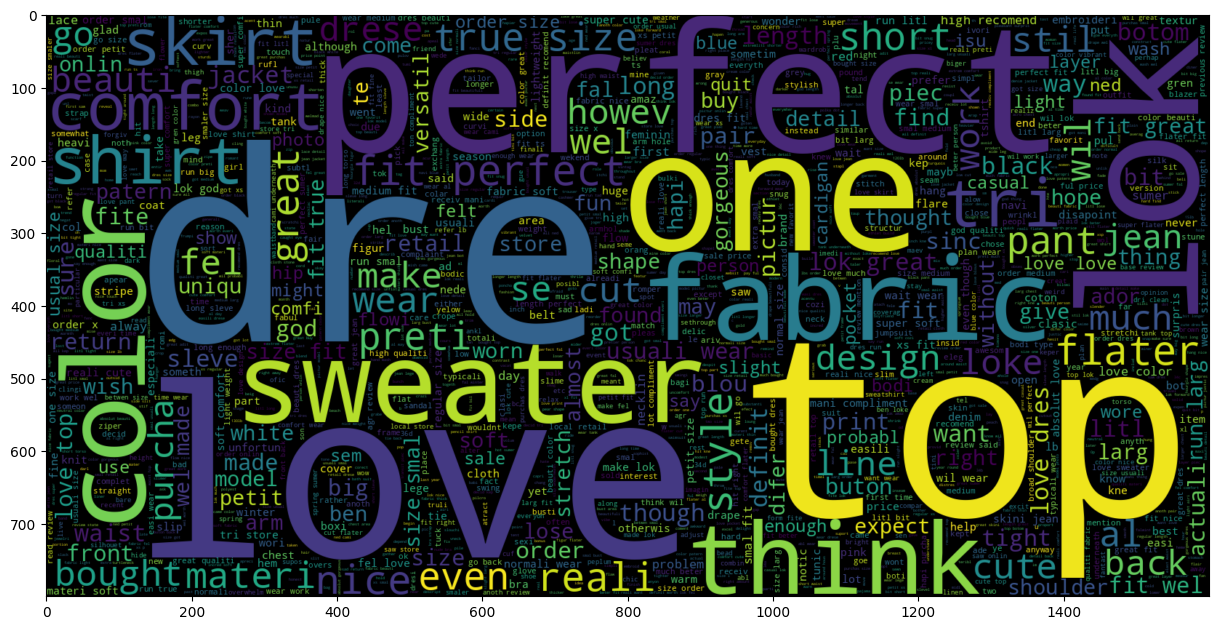

In [137]:
plt.figure(figsize = (15,15)) # Text that is recommended
wc=WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Recommended'].review_text))
plt.imshow(wc, interpolation ="bilinear")


Most Common Words in Not Recommended Review

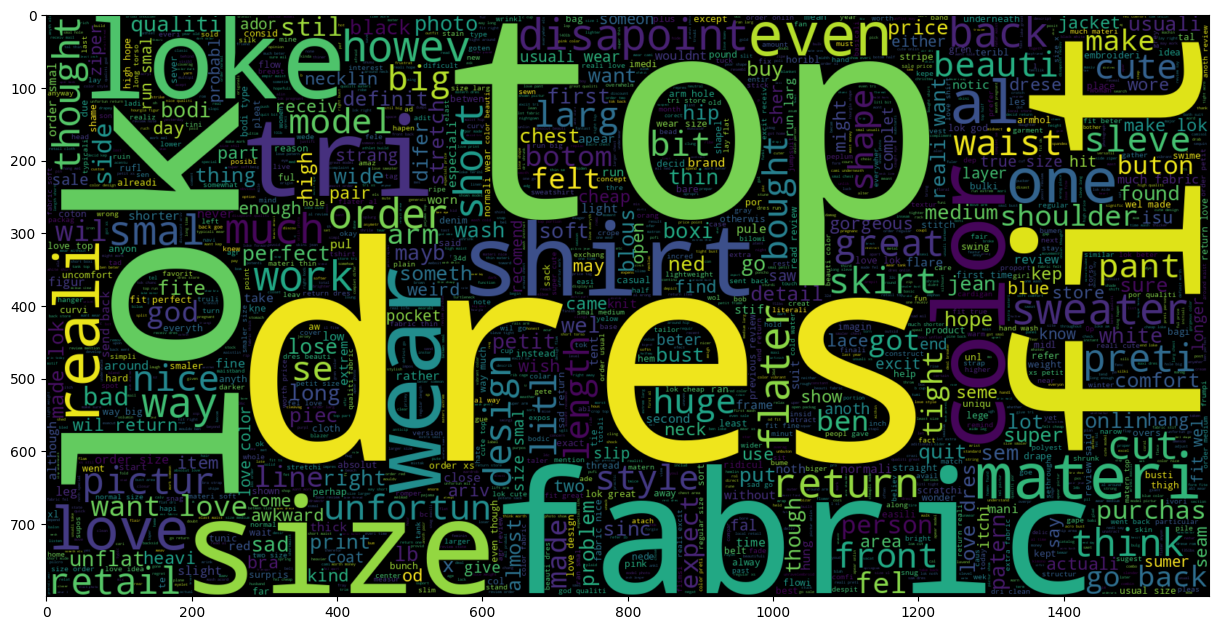

In [138]:
plt.figure(figsize = (15,15)) # Text that is not recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Not Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

Modelling using Multinomial Naive Bayes

Split the data and count the vectorize in each words

The next step is to create a numerical feature vector for each document and split them into train data and test data.

In [139]:
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
cv=CountVectorizer()

X_train = cv.fit_transform(train_data['review_text'])
y_train = train_data['recommended']
X_test = cv.transform(test_data['review_text'])
y_test = test_data['recommended']



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Multinomial Naive Bayes Modelling

In [140]:
nb= MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [141]:
nb_predict=nb.predict(X_test)

# Matrix Evaluation

After we get the result from our modelling, the next step is evaluate our model using matrix evaluation as follows:

Where :
TP (True Positive) : Predicted positive and the actual's positive
TN (True Negative) : Predicted negative and the actual's negative
FP (False Positive) : Predicted positive but the actual's negative
FN (False Negative) : Predicted negative but the actual's positive

In [142]:
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.8893146019582802


In [143]:
nb_report1 = recall_score(y_test,nb_predict,pos_label='Recommended',average='binary')
print('Recall:',nb_report1)

Recall: 0.9478036175710595


In [144]:
nb_report2 = precision_score(y_test,nb_predict,pos_label='Recommended',average='binary')
print('Precision:',nb_report2)

Precision: 0.9202207727044657
